In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import config

# Dermatology Dataset

In [2]:
from dataset import DermaDataset

train_dir = ['train', 'validation']
dataset_dir = list(map(lambda x: os.path.join(config.DERMA_DATASET_DIR, x), train_dir))

dataset = DermaDataset(dataset_dir)
x, y = dataset.get(dataframe=True)

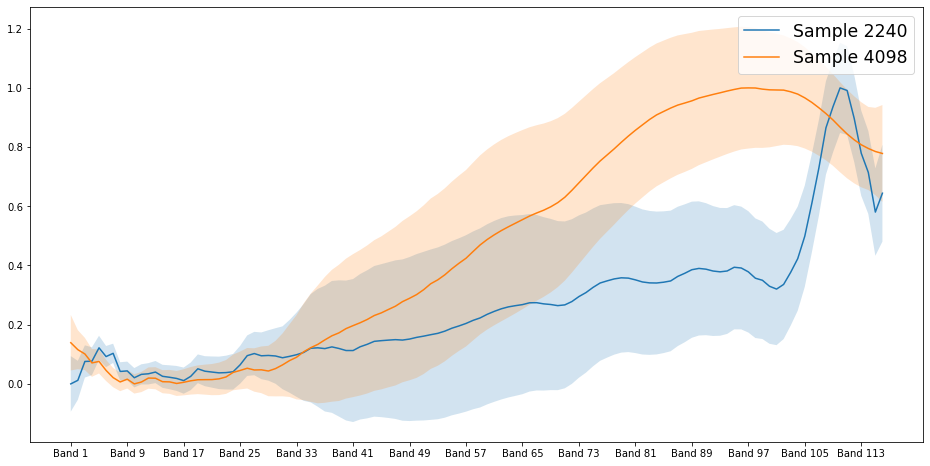

In [3]:
fig, ax = plt.subplots(figsize=(16, 8))
sample_idx = 2240
ax.plot(x.iloc[sample_idx], label='Sample {}'.format(sample_idx))
ax.fill_between(x.iloc[sample_idx].index, x.iloc[sample_idx] - x.std(), x.iloc[sample_idx] + x.std(), alpha=0.2)
ax.set_xticks(np.arange(0, 116, 10))

sample_idx = 4098
ax.plot(x.iloc[sample_idx], label='Sample {}'.format(sample_idx))
ax.fill_between(x.iloc[sample_idx].index, x.iloc[sample_idx] - x.std(), x.iloc[sample_idx] + x.std(), alpha=0.2)
ax.set_xticks(np.arange(0, 116, 8))
plt.legend(fontsize='xx-large')
plt.show()

# Normalize (Z-Score)

In [4]:
std = x.std().values
mean = x.mean().values

x_normalized = (x.values - mean) / std
x_normalized = pd.DataFrame(x_normalized, columns=x.columns)

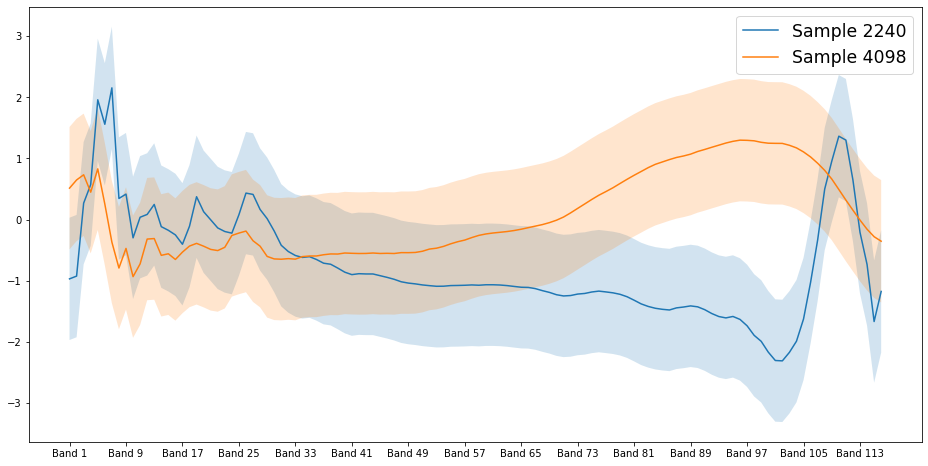

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))
sample_idx = 2240
ax.plot(x_normalized.iloc[sample_idx], label='Sample {}'.format(sample_idx))
ax.fill_between(x_normalized.iloc[sample_idx].index, x_normalized.iloc[sample_idx] - x_normalized.std(), x_normalized.iloc[sample_idx] + x_normalized.std(), alpha=0.2)
ax.set_xticks(np.arange(0, 116, 10))

sample_idx = 4098
ax.plot(x_normalized.iloc[sample_idx], label='Sample {}'.format(sample_idx))
ax.fill_between(x_normalized.iloc[sample_idx].index, x_normalized.iloc[sample_idx] - x_normalized.std(), x_normalized.iloc[sample_idx] + x_normalized.std(), alpha=0.2)
ax.set_xticks(np.arange(0, 116, 8))
plt.legend(fontsize='xx-large')
plt.show()

# Redundancy
## Correlation

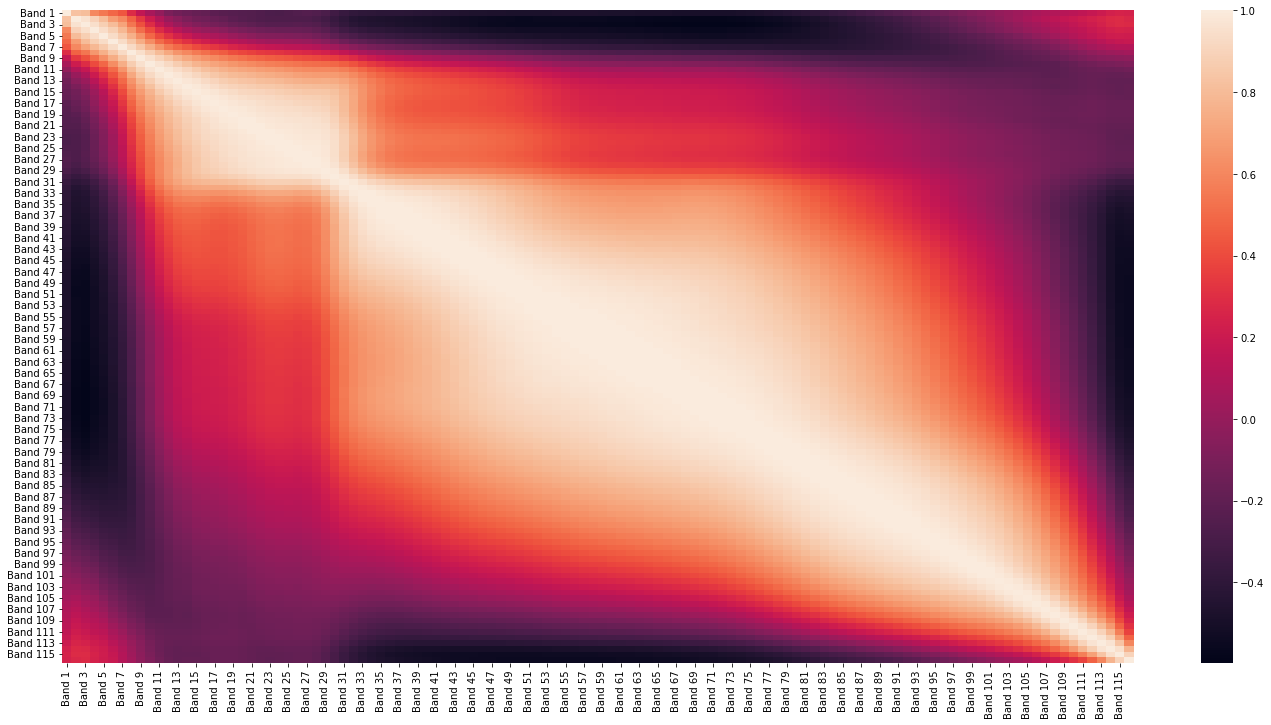

In [6]:
corrMatrix = x_normalized.corr()
fig, ax = plt.subplots(figsize=(24,12)) 
sns.heatmap(corrMatrix, annot=False)
plt.show()

## Variance Inflation Factor (VIF)

In [22]:
from statsmodels.api import OLS
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectorMixin
from sklearn.utils.validation import check_is_fitted

from statsmodels.api import OLS


class InterbandRedundancySelector(BaseEstimator, SelectorMixin):
    '''
        Feature selector that removes the features with high-multicollinearity in 
        adjacent features.

        This feature selection algorithm looks only at the features (X), not the
        desired outputs (y), and can thus be used for unsupervised learning.

        Parameters
        ----------
        threshold : float, default=5
            Features with a Variational Inflation Factor (VIF) bigger than this 
            threshold will be removed. The default is to keep all features with a
            VIF lower than 5, i.e. remove the features that have a low-multicollinearity
            with the adjacent features.

        Attributes
        ----------
        vif_ : array, shape (n_features, n_features)
            VIF computed.

        mask_ : array, shape (n_features,)
            1-D array which contains the selected features based on VIF.
    '''

    def __init__(self, threshold=5):
        if threshold < 0:
            raise ValueError(f"Threshold must be non-negative. Got: {self.threshold}")
        
        self.threshold = threshold

    def fit(self, X, y=None):
        '''
            Parameters
            ----------
            X : array, shape (n_samples, n_features)
                Data from which to compute the VIF between different features, where `n_samples` is
                the number of samples and `n_features` is the number of features.

            y : any, default=None
                Ignored. This parameter exists only for compatibility with
                sklearn.pipeline.Pipeline.

            Returns
            -------
            self : object
                Returns the instance itself.
        '''

        n_features = X.shape[1]
        reg_score = np.zeros((n_features, n_features)) # Coefficient of determination of predictions per feature
        for independent_feature_idx in np.arange(n_features):
            for dependent_feature_idx in np.arange(independent_feature_idx, n_features):
                model = OLS(X[:, independent_feature_idx], X[:, dependent_feature_idx])
                results = model.fit()
                reg_score[independent_feature_idx, dependent_feature_idx] = results.rsquared
                reg_score[dependent_feature_idx, independent_feature_idx] = results.rsquared

        self.vif_ = 1 / (1 - reg_score + 1e-8)
        
        features_available = np.arange(0, n_features)
        self.mask_ = np.zeros(features_available.size, dtype=np.uint)

        features_selected_idx = np.linspace(0, features_available.size, 5, dtype=np.uint)[1:-1]
        while(features_available.size > 0):
            features_selected = features_available[features_selected_idx]
            self.mask_[features_selected] = 1
            
            band_redundancy = tuple(map(lambda x: selector._clusterize(x, features_available), features_selected))
            band_redundancy = np.unique(np.concatenate(band_redundancy))

            # Remove features selected and those which have high-multicollinearity
            features_available = features_available[ np.logical_not(np.in1d(features_available, band_redundancy, assume_unique=True)) ]

            features_selected_idx = np.linspace(0, features_available.size, 5, dtype=np.uint)[1:-1]

        return self

    def _clusterize(self, independent_var: int, dependent_vars: np.ndarray):
        '''
            Clusterize taking into account the index of the independent variable and
            getting consecutive values (...)

            Parameters
            ----------
                independent_var : int:
                    The feature which is used as independent variable. 

                dependent_vars : array, shape (n_vars, )
                    The features which are gonna be analyzed for multicollinearity. This
                    arrays must contain the independent variable, where `n_vars` is the
                    number of depedentant variabbles.

            Return
            ------
                An array with the features clusterized.
        '''
        vif = self.vif_[independent_var, dependent_vars]
        high_multicollinearity = vif>self.threshold
        
        consecutive_idx = (dependent_vars[1:]-dependent_vars[:-1])==1
        independent_idx = np.argwhere(vif==vif.max()).item()

        index_consecutive_left = consecutive_idx[:independent_idx]
        if index_consecutive_left.all(): 
            left_distance = 0
        else:        
            left_distance = (np.argwhere(index_consecutive_left == False)[::-1][0].item() + 1)

        index_consecutive_right = consecutive_idx[independent_idx:]
        if index_consecutive_right.all(): 
            right_distance = index_consecutive_right.size + independent_idx + 1
        else:
            right_distance = (np.argwhere(index_consecutive_right == False)[0].item() +
                                independent_idx + 1)
        
        result = dependent_vars[left_distance:right_distance][high_multicollinearity[left_distance:right_distance]]
        return result

    def _get_support_mask(self):
        check_is_fitted(self)
        return self.mask_.astype(bool)


In [23]:
selector = InterbandRedundancySelector(10)
selector.fit(x_normalized.values)
# selector.fit_transform(x_normalized.values)
print("Mask: {}".format(selector.mask_))

Mask: [1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0
 1 0 1 1 1]


## Show results!

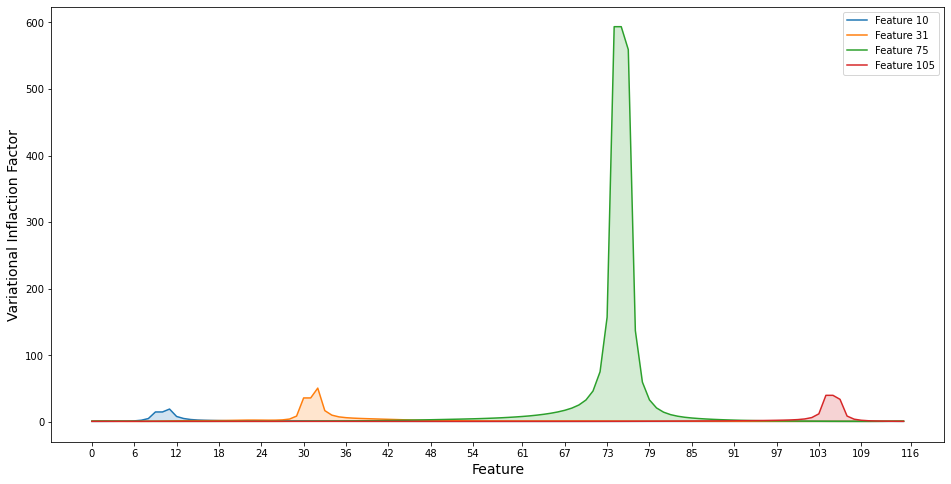

In [78]:
selected_features = [10, 31, 75, 105]

fig, ax = plt.subplots(figsize=(16, 8))
for feature in selected_features:
    vif = selector.vif_[feature].copy()
    max_value_idx = np.argwhere(vif == vif.max()).item()
    vif[max_value_idx] = vif[max_value_idx-1] if max_value_idx != 0 else vif[max_value_idx+1] 
    ax.plot(vif, label='Feature {}'.format(feature))
    ax.fill_between(np.arange(vif.size), np.zeros(vif.shape), vif, alpha=.2)

ax.set_xticks(np.linspace(0, 116, 20, dtype=int))
ax.set_xlabel('Feature', fontsize=14)
ax.set_ylabel('Variational Inflaction Factor', fontsize=14)
plt.legend()
plt.show()

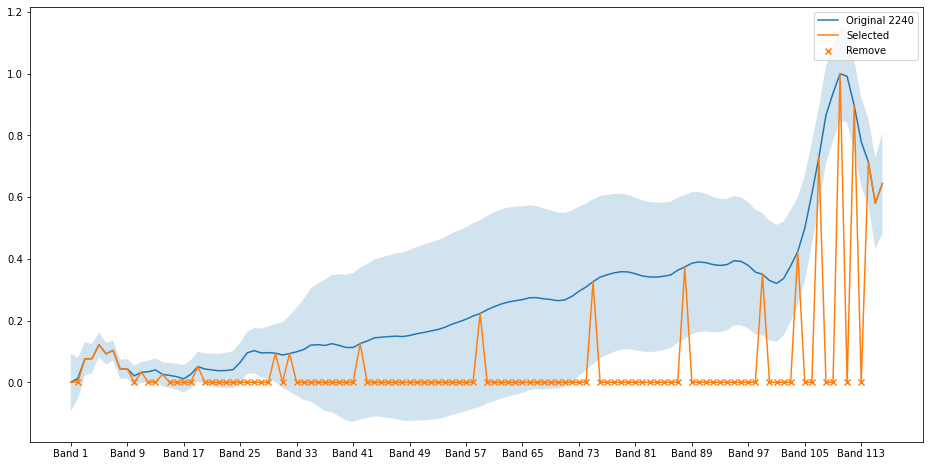

In [80]:
fig, ax = plt.subplots(figsize=(16, 8))
sample_idx = 2240
ax.plot(x.iloc[sample_idx], label='Original {}'.format(sample_idx))
ax.fill_between(x.iloc[sample_idx].index, x.iloc[sample_idx] - x.std(), x.iloc[sample_idx] + x.std(), alpha=0.2)
ax.set_xticks(np.arange(0, 116, 8))

data = x.iloc[sample_idx].copy()
data[np.logical_not(selector.mask_)] = 0
ax.plot(data, label='Selected')

features_remove_idx = np.where(selector.mask_ == False)[0]
ax.scatter(features_remove_idx, np.zeros(features_remove_idx.size), marker='x', label='Remove')

plt.legend()
plt.show()

# New data

In [ ]:
new_x = selector.transform(x_normalized.values)
print('Shape {}'.format(new_x.shape))